In [353]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN
from tensorflow.keras.optimizers import Adam
import pandas as pd
import yfinance as yf

# **Central Moving Average Implementation**

In [354]:
def central_moving_average(data, window_size):
    if window_size % 2 != 0:
        raise ValueError("Window size must be even for this calculation.")

    half_window = window_size // 2
    n = len(data)

    cma = []

    for t in range(half_window, n - half_window + 1):
        # Calculate Vol_t_pre
        vol_t_pre = np.mean(data[t - half_window:t + half_window - 1 ])

        # Calculate Vol_t_next
        vol_t_next = np.mean(data[t-half_window+1:t + half_window])

        # Compute CMA_t
        cma_t = (vol_t_pre + vol_t_next) / 2
        cma.append(cma_t)

    return cma

# **Build NN Models using CMA data**

In [355]:
def build_lstm_cma(input_shape):
    # input_shape: (timestep = 1, (price, volume) = 2)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(input_shape[0], input_shape[1])))
    model.add(Dense(1))  # Output layer for predictions
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [356]:
def build_rnn_cma(input_shape):
    # input_shape: (timestep = 1, (price, volume))
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(input_shape[0], input_shape[1])))
    model.add(Dense(1))  # Output layer for predictions
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# **Build NN Models using Sequential data**

In [357]:
def build_lstm_seq(input_shape):
    # input_shape: (timestep = 4, (price, volume) = 2)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(input_shape[0], input_shape[1])))
    model.add(Dense(1))  # Output layer for predictions
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [358]:
def build_rnn_seq(input_shape):
    # input_shape: (timestep = 4, (price, volume))
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(input_shape[0], input_shape[1])))
    model.add(Dense(1))  # Output layer for predictions
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# **Preprocess data**

In [359]:
def preprocess_data_cma(data, m):
    price = data['Close'].values # Target variable
    volume = data['Volume'].values

    # Compute CMA
    cma_price = central_moving_average(price, m)
    cma_volume = central_moving_average(volume, m)

    # Prepare input features
    price_features = cma_price[:-1] # All but the last value (input for model)
    volume_features = cma_volume[:-1]

    features = np.column_stack((price_features, volume_features))  # Combine price and volume

    # Target: Next day's price
    price_targets = price[m:] # First (m) features are used to predict (m+1) label

    # Train/test split
    X = features
    y = price_targets[:len(features)] # make sure X and y are the same size

    # Split into training and temporary [Ensure shuffle=False to maintain the temporal order]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)  # train (60%) and temp (40%)

    # Split temporary into training and validation [Ensure shuffle=False to maintain the temporal order]
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False) # validation (20%) and testing (20%)


    # Reshape for Model
    X_train = X_train.reshape(X_train.shape[0], 1, 2)  # Reshape from (samples, features) to (samples, timesteps, features)
    X_val = X_val.reshape(X_val.shape[0], 1, 2)
    X_test = X_test.reshape(X_test.shape[0], 1, 2)


    return X_train, X_val, X_test, y_train, y_val, y_test

In [360]:
def preprocess_data_seq(data, m):
    price = data['Close'].values # Target variable
    volume = data['Volume'].values

    features = np.column_stack((price, volume))  # Combine price and volume

    # Normailize data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(len(data) - m):
        X.append(features[i:i + m])  # Input features (m days)
        y.append(price[i + m])  # Target (m+1 day's price)

    X = np.array(X)
    y = np.array(y)

    # Split into training and temporary [Ensure shuffle=False to maintain the temporal order]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)  # train (60%) and temp (40%)

    # Split temporary into training and validation [Ensure shuffle=False to maintain the temporal order]
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False) # validation (20%) and testing (20%)


    return X_train, X_val, X_test, y_train, y_val, y_test

# **Predict Price Change using CMA**

In [361]:
def predict_price_change_lstm_cma(X_train, X_val, X_test, y_train, y_val, y_test, epochs=10, m=4):
    # Build and train the model
    model = build_lstm_cma(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X_test)

    #Evaluate model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"Test Loss LSTM: {loss:.4f}")
    print(f"Test MAE LSTM: {mae:.4f}")
    print(f"Test RMSE LSTM: {rmse:.4f}")
    print(f"Test R-squared LSTM: {r2:.4f}")

    return model, predictions, y_test

In [362]:
def predict_price_change_rnn_cma(X_train, X_val, X_test, y_train, y_val, y_test, epochs=10, m=4):
    # Build and train the model
    model = build_rnn_cma(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X_test)

    #Evaluate model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"Test Loss RNN: {loss:.4f}")
    print(f"Test MAE RNN: {mae:.4f}")
    print(f"Test RMSE RNN: {rmse:.4f}")
    print(f"Test R-squared RNN: {r2:.4f}")

    return model, predictions, y_test

# **Predict Price Change using Sequences**

In [363]:
def predict_price_change_lstm_seq(X_train, X_val, X_test, y_train, y_val, y_test, epochs=10, m=4):
    # Build and train the model
    model = build_lstm_seq(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X_test)

    #Evaluate model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"Test Loss LSTM: {loss:.4f}")
    print(f"Test MAE LSTM: {mae:.4f}")
    print(f"Test RMSE LSTM: {rmse:.4f}")
    print(f"Test R-squared LSTM: {r2:.4f}")

    return model, predictions, y_test

In [364]:
def predict_price_change_rnn_seq(X_train, X_val, X_test, y_train, y_val, y_test, epochs=10, m=4):
    # Build and train the model
    model = build_rnn_seq(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X_test)

    #Evaluate model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"Test Loss RNN: {loss:.4f}")
    print(f"Test MAE RNN: {mae:.4f}")
    print(f"Test RMSE RNN: {rmse:.4f}")
    print(f"Test R-squared RNN: {r2:.4f}")

    return model, predictions, y_test

In [365]:
# Hyperparameters
epochs=10
m=4 #Sliding Window Size

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 871675558100992.0000 - mae: 23531548.0000 - val_loss: 73081947160576.0000 - val_mae: 8265807.5000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19655848624128.0000 - mae: 3726073.0000 - val_loss: 773430378496.0000 - val_mae: 850174.3750
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 348235202560.0000 - mae: 509156.7188 - val_loss: 89180504064.0000 - val_mae: 288930.6250
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25978277888.0000 - mae: 134778.1406 - val_loss: 1949122432.0000 - val_mae: 42501.3398
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 858281280.0000 - mae: 25156.5664 - val_loss: 117293408.0000 - val_mae: 10624.5244
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31703724.0000 - mae: 4768.5796 - val_loss: 1060129.1250 - val_mae: 646.0941
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1191728.6250 - mae: 865.7092 - val_loss: 1396478.5000 - val_mae: 1108

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 99210944218923008.0000 - mae: 303913120.0000 - val_loss: 19995194476724224.0000 - val_mae: 136726208.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7978672698949632.0000 - mae: 81696256.0000 - val_loss: 14444528664576.0000 - val_mae: 3674659.0000
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18479967109120.0000 - mae: 3667064.7500 - val_loss: 19785685401600.0000 - val_mae: 4301163.5000
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6575960883200.0000 - mae: 2176118.2500 - val_loss: 402060869632.0000 - val_mae: 612900.2500
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 215272849408.0000 - mae: 433310.4375 - val_loss: 566465536.0000 - val_mae: 23202.0762
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2265323264.0000 - mae: 44309.7891 - val_loss: 108089736.0000 - val_mae: 10220.8916
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35364436.0000 - mae: 5233.9263 - val_loss:

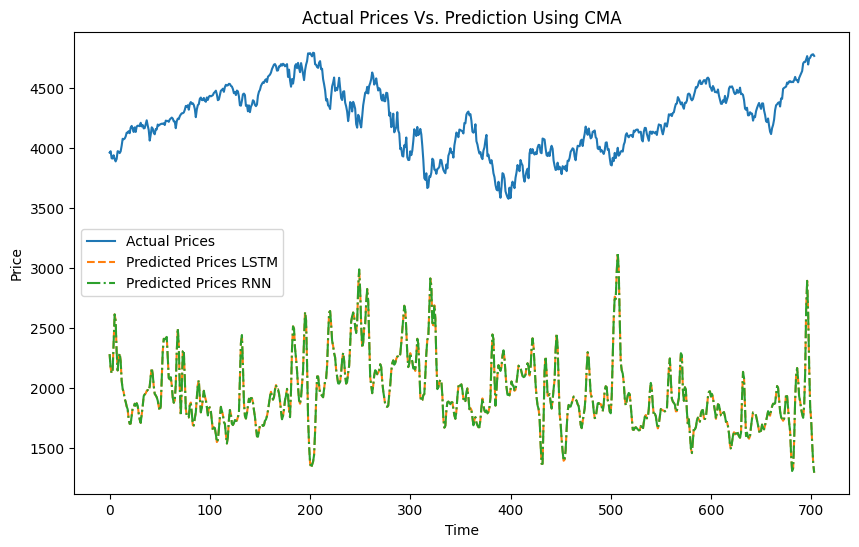

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3432588.5000 - mae: 1790.3126 - val_loss: 9469457.0000 - val_mae: 3056.8367
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3392125.5000 - mae: 1779.5570 - val_loss: 9450541.0000 - val_mae: 3053.7920
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3419189.7500 - mae: 1787.7712 - val_loss: 9051108.0000 - val_mae: 2988.6899
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3138209.5000 - mae: 1709.4364 - val_loss: 6080999.5000 - val_mae: 2448.3049
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1497013.8750 - mae: 1131.6963 - val_loss: 198018.3906 - val_mae: 401.3448
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 93330.7812 - mae: 236.8342 - val_loss: 199746.5938 - val_mae: 406.4904
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 72339.5234 - mae: 220.5107 - val_loss: 121863.8750 - val_mae: 301.1198
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 58068.6914 - mae: 195.210

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3426617.0000 - mae: 1789.9906 - val_loss: 9469944.0000 - val_mae: 3056.9155
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3515628.7500 - mae: 1812.0052 - val_loss: 9456390.0000 - val_mae: 3054.7322
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3403728.0000 - mae: 1781.9874 - val_loss: 9159503.0000 - val_mae: 3006.5022
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3154476.5000 - mae: 1713.8705 - val_loss: 6471402.0000 - val_mae: 2525.9722
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1628168.3750 - mae: 1176.6311 - val_loss: 162463.1094 - val_mae: 353.8533
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 109272.8594 - mae: 252.0955 - val_loss: 197739.3906 - val_mae: 404.4325
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 69738.1797 - mae: 215.4772 - val_loss: 132218.5938 - val_mae: 320.0760
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 61572.5039 - mae: 200.147

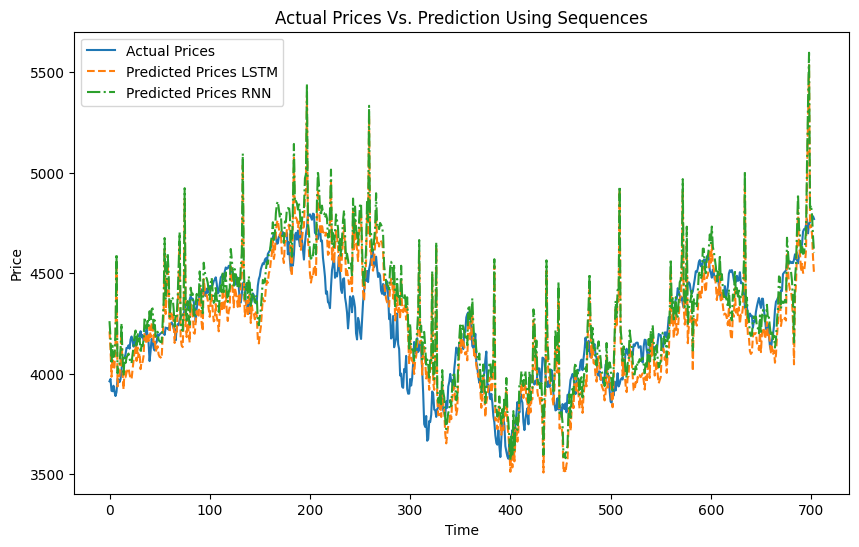

[*********************100%***********************]  1 of 1 completed


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 88091009024.0000 - mae: 206066.3125 - val_loss: 5032136192.0000 - val_mae: 64442.6992
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1302557952.0000 - mae: 28393.7969 - val_loss: 1348669824.0000 - val_mae: 31290.8242
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 191428064.0000 - mae: 10440.9727 - val_loss: 164232272.0000 - val_mae: 8572.3477
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 63818452.0000 - mae: 6746.5933 - val_loss: 87033384.0000 - val_mae: 6808.8281
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62043388.0000 - mae: 6649.1372 - val_loss: 83439816.0000 - val_mae: 7176.2344
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59478628.0000 - mae: 6539.1211 - val_loss: 85928032.0000 - val_mae: 6805.6792
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61136208.0000 - mae: 6518.9492 - val_loss: 84712936.0000 - val_mae: 6822.3159
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 264548795809792.0000 - mae: 14089871.0000 - val_loss: 233394428444672.0000 - val_mae: 14575631.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43712361005056.0000 - mae: 5579722.0000 - val_loss: 18085796904960.0000 - val_mae: 4059252.7500
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2963921174528.0000 - mae: 1401470.2500 - val_loss: 169600221184.0000 - val_mae: 395302.2188
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17300670464.0000 - mae: 94933.7969 - val_loss: 12688962560.0000 - val_mae: 104579.7500
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2306542336.0000 - mae: 36521.5273 - val_loss: 217860448.0000 - val_mae: 10090.0693
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63160764.0000 - mae: 6603.4561 - val_loss: 80377976.0000 - val_mae: 7350.8311
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56180984.0000 - mae: 6284.3027 - val_loss: 82473448.0000 - val_mae: 

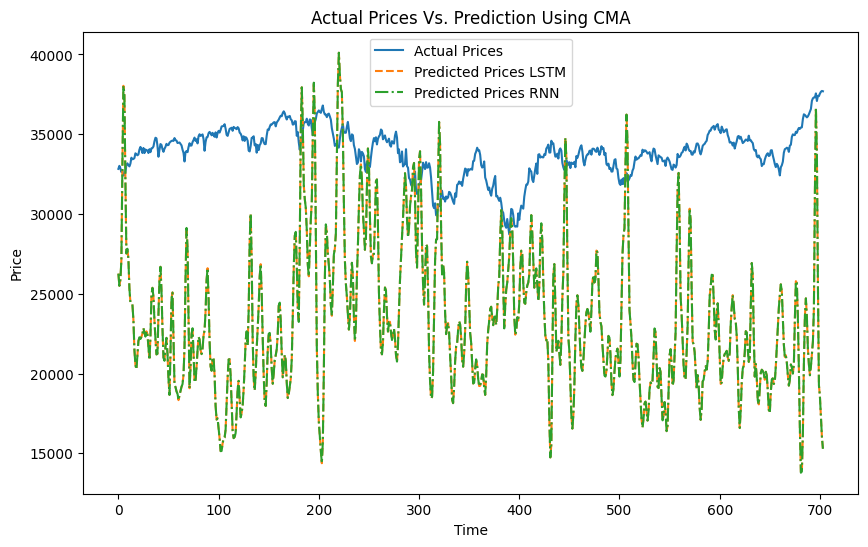

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 276032608.0000 - mae: 16151.4082 - val_loss: 714926336.0000 - val_mae: 26647.2207
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 273813504.0000 - mae: 16064.1348 - val_loss: 714726400.0000 - val_mae: 26643.4863
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 273810176.0000 - mae: 16063.7900 - val_loss: 710381888.0000 - val_mae: 26562.1621
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 270361824.0000 - mae: 15967.1162 - val_loss: 675088640.0000 - val_mae: 25891.3496
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 248579792.0000 - mae: 15303.2939 - val_loss: 505259840.0000 - val_mae: 22379.6113
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 164929136.0000 - mae: 12384.3096 - val_loss: 114700832.0000 - val_mae: 10463.2559
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24883802.0000 - mae: 4298.4111 - val_loss: 12525146.0000 - val_mae: 2316.0146
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 270951552.0000 - mae: 15974.4453 - val_loss: 714931776.0000 - val_mae: 26647.3203
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 270356064.0000 - mae: 15972.0889 - val_loss: 714778816.0000 - val_mae: 26644.4609
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 269676320.0000 - mae: 15938.5840 - val_loss: 711124032.0000 - val_mae: 26576.0332
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 267911280.0000 - mae: 15892.9834 - val_loss: 678452288.0000 - val_mae: 25955.8926
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 253461696.0000 - mae: 15462.1602 - val_loss: 519343008.0000 - val_mae: 22691.3984
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 172630112.0000 - mae: 12684.4980 - val_loss: 142489152.0000 - val_mae: 11714.0879
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31845120.0000 - mae: 4954.1929 - val_loss: 11428124.0000 - val_mae: 2203.7458
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━

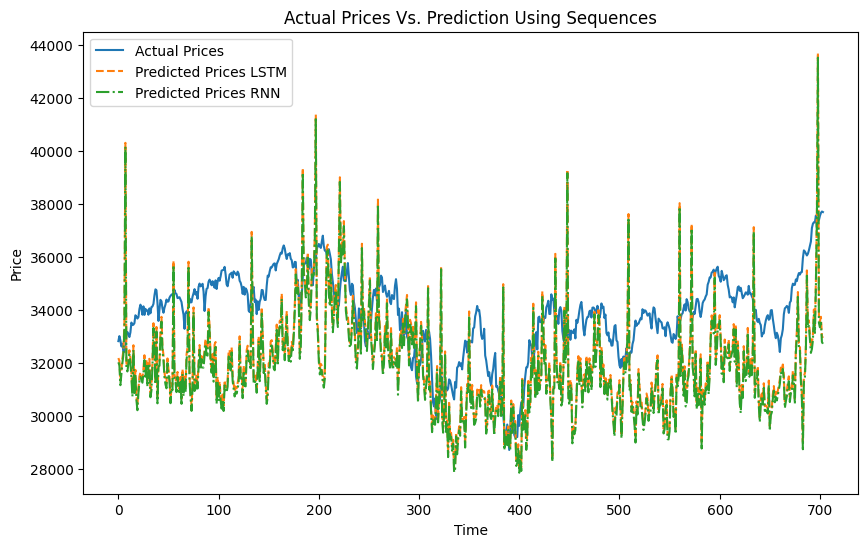

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 466044116271104.0000 - mae: 20205188.0000 - val_loss: 9676337971200.0000 - val_mae: 2813630.2500
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1886230937600.0000 - mae: 1215941.2500 - val_loss: 797222961152.0000 - val_mae: 806269.8125
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94509170688.0000 - mae: 271874.9375 - val_loss: 13004995584.0000 - val_mae: 104121.7266
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3071067648.0000 - mae: 48756.8477 - val_loss: 189502928.0000 - val_mae: 13249.8350
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 218611680.0000 - mae: 13502.8018 - val_loss: 75775392.0000 - val_mae: 6460.8145
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17849888.0000 - mae: 3597.0776 - val_loss: 17224756.0000 - val_mae: 3948.4858
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2811641.2500 - mae: 1349.7035 - val_loss: 9211064.0000 - val_mae: 2752.8867

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1441713094656.0000 - mae: 986136.0625 - val_loss: 324630577152.0000 - val_mae: 516289.2188
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37343027200.0000 - mae: 162102.5938 - val_loss: 14080651264.0000 - val_mae: 106127.6562
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1430249344.0000 - mae: 31999.1289 - val_loss: 416252832.0000 - val_mae: 17128.5742
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50209028.0000 - mae: 6003.8101 - val_loss: 29454866.0000 - val_mae: 5277.8955
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5055161.5000 - mae: 1815.4011 - val_loss: 9057921.0000 - val_mae: 2672.3643
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2877829.7500 - mae: 1410.9521 - val_loss: 11371731.0000 - val_mae: 3067.8479
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3108024.0000 - mae: 1451.2572 - val_loss: 9757417.0000 - val_mae: 2800.7781
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━

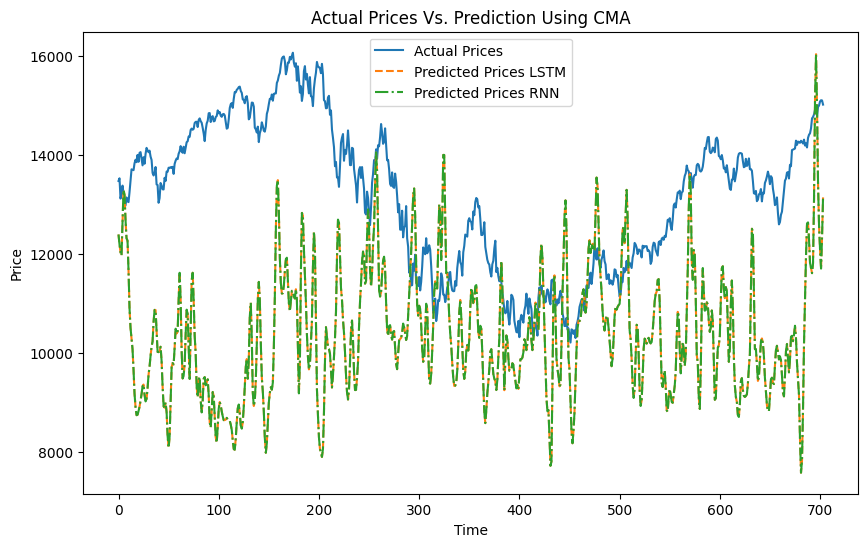

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 19150610.0000 - mae: 4134.3647 - val_loss: 85506696.0000 - val_mae: 9050.0654
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18963844.0000 - mae: 4121.1821 - val_loss: 85469176.0000 - val_mae: 9048.1123
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19310454.0000 - mae: 4158.0703 - val_loss: 84754888.0000 - val_mae: 9011.1553
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19198536.0000 - mae: 4144.9521 - val_loss: 78730088.0000 - val_mae: 8688.1836
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17099240.0000 - mae: 3887.2239 - val_loss: 52846244.0000 - val_mae: 7128.8496
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8199883.0000 - mae: 2535.6218 - val_loss: 6672401.5000 - val_mae: 2490.5381
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 796110.2500 - mae: 748.3793 - val_loss: 3597477.7500 - val_mae: 1800.5192
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 19315456.0000 - mae: 4158.2349 - val_loss: 85504720.0000 - val_mae: 9049.9648
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19438862.0000 - mae: 4176.4150 - val_loss: 85455456.0000 - val_mae: 9047.4346
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19653786.0000 - mae: 4192.4004 - val_loss: 84487840.0000 - val_mae: 8997.3789
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19033318.0000 - mae: 4119.7944 - val_loss: 76391648.0000 - val_mae: 8560.2773
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15319937.0000 - mae: 3676.1167 - val_loss: 41896004.0000 - val_mae: 6353.2407
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5253281.5000 - mae: 1944.2504 - val_loss: 2081947.6250 - val_mae: 1333.6802
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 747814.8125 - mae: 717.8671 - val_loss: 3168298.2500 - val_mae: 1687.8488
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 601597

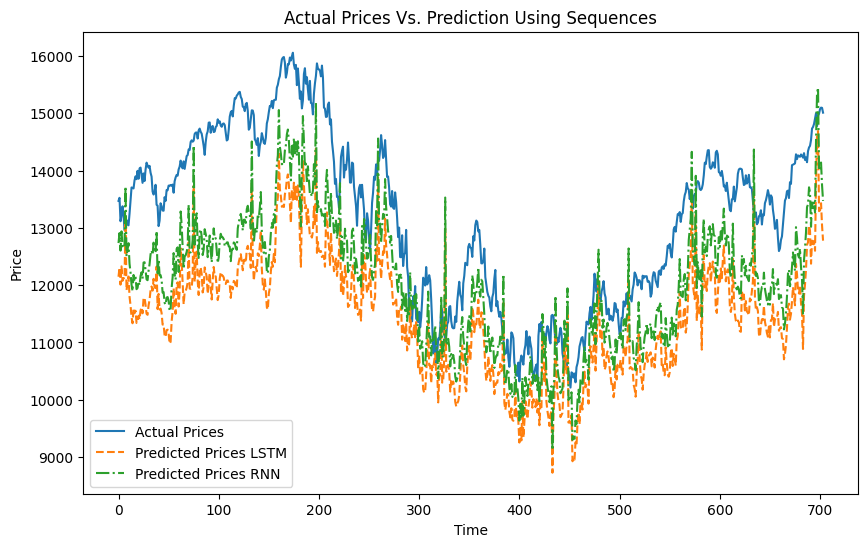

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8727226442842112.0000 - mae: 88530352.0000 - val_loss: 591796832829440.0000 - val_mae: 23521978.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 172295028998144.0000 - mae: 10913430.0000 - val_loss: 16912783245312.0000 - val_mae: 3976579.7500
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9024929005568.0000 - mae: 2784416.5000 - val_loss: 2573302784.0000 - val_mae: 48932.7539
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 65107402752.0000 - mae: 227370.9531 - val_loss: 6268983296.0000 - val_mae: 76441.6562
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1769304320.0000 - mae: 36481.5859 - val_loss: 502582784.0000 - val_mae: 21785.6250
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 120240968.0000 - mae: 9112.3301 - val_loss: 16336106.0000 - val_mae: 3763.3975
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4930228.5000 - mae: 1812.7499 - val_loss: 1554009.8750 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 134204390113280.0000 - mae: 9265760.0000 - val_loss: 353758183424.0000 - val_mae: 575206.9375
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1777900322816.0000 - mae: 1110794.1250 - val_loss: 374632611840.0000 - val_mae: 591715.7500
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94646362112.0000 - mae: 259165.7969 - val_loss: 7964703232.0000 - val_mae: 86399.4688
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2419896576.0000 - mae: 42445.4297 - val_loss: 94379912.0000 - val_mae: 9490.2754
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101150504.0000 - mae: 8738.2529 - val_loss: 5580390.0000 - val_mae: 2130.0652
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2429734.5000 - mae: 1320.3580 - val_loss: 348854.1250 - val_mae: 367.9781
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 253848.3438 - mae: 404.4134 - val_loss: 283942.1875 - val_mae: 481.0090
Epoch 8/10
33/33 ━━━━━━━━━━

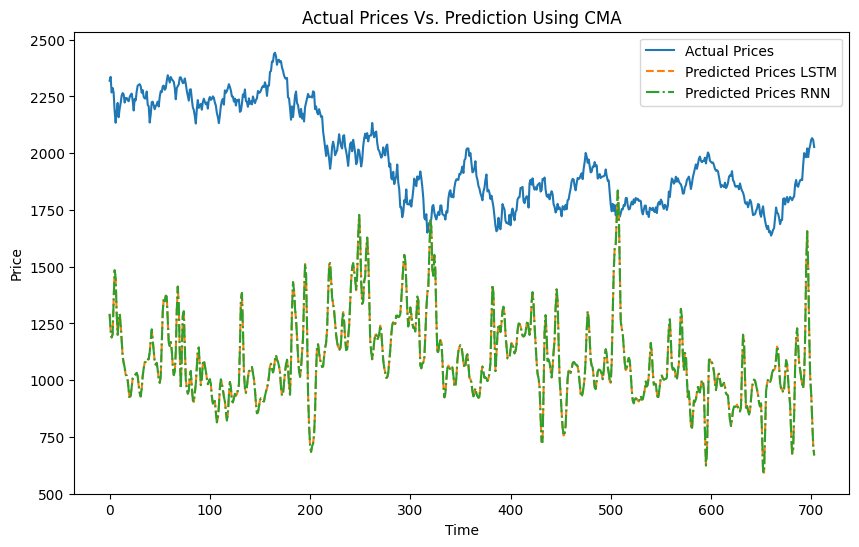

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1163973.7500 - mae: 1044.8594 - val_loss: 2597003.0000 - val_mae: 1596.2094
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1178623.7500 - mae: 1052.0112 - val_loss: 2584756.2500 - val_mae: 1592.4449
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1152456.7500 - mae: 1039.4249 - val_loss: 2316970.2500 - val_mae: 1507.5079
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 932539.3125 - mae: 928.7961 - val_loss: 712072.1875 - val_mae: 827.2075
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 148536.2188 - mae: 314.7958 - val_loss: 32763.3379 - val_mae: 134.0200
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20543.3164 - mae: 116.7820 - val_loss: 30888.3809 - val_mae: 137.8673
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16773.3613 - mae: 102.8038 - val_loss: 27671.3633 - val_mae: 129.1556
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14725.2539 - mae: 94.6468 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1189735.5000 - mae: 1056.6890 - val_loss: 2597544.7500 - val_mae: 1596.3777
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1196620.7500 - mae: 1060.4381 - val_loss: 2591530.5000 - val_mae: 1594.5239
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1143893.3750 - mae: 1036.0028 - val_loss: 2460531.5000 - val_mae: 1553.5878
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1033233.9375 - mae: 981.2806 - val_loss: 1363908.5000 - val_mae: 1152.8960
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 371579.0938 - mae: 540.3386 - val_loss: 43286.4727 - val_mae: 130.6848
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31639.5996 - mae: 136.2184 - val_loss: 36496.1602 - val_mae: 156.7212
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19414.1484 - mae: 111.3309 - val_loss: 31354.6875 - val_mae: 141.0204
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16963.8379 - mae: 103.6780 - val

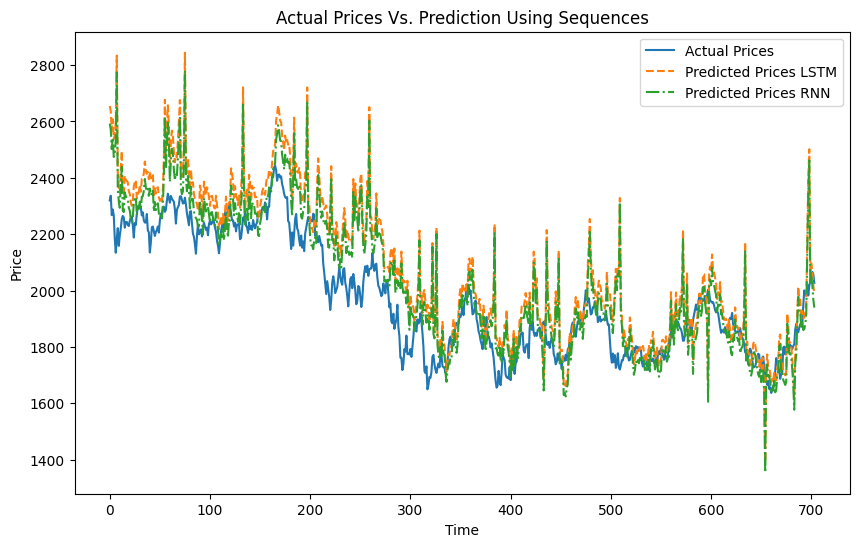

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3655954008637440.0000 - mae: 55978340.0000 - val_loss: 1618694242304.0000 - val_mae: 1231127.2500
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17543687307264.0000 - mae: 3493752.2500 - val_loss: 1251058122752.0000 - val_mae: 1080555.7500
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 567446863872.0000 - mae: 664600.1875 - val_loss: 25025564672.0000 - val_mae: 153858.8906
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21458343936.0000 - mae: 126964.1016 - val_loss: 482626560.0000 - val_mae: 21857.0977
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1488911104.0000 - mae: 35221.7812 - val_loss: 194435600.0000 - val_mae: 12025.4414
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 116776192.0000 - mae: 9015.5762 - val_loss: 36607620.0000 - val_mae: 5712.8696
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11856012.0000 - mae: 2868.7258 - val_loss: 17942878.0000 - val_m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 465263807954944.0000 - mae: 16882960.0000 - val_loss: 43040680968192.0000 - val_mae: 6342542.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11414960865280.0000 - mae: 2818957.2500 - val_loss: 883456802816.0000 - val_mae: 909782.4375
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 267483004928.0000 - mae: 444594.3125 - val_loss: 56114900992.0000 - val_mae: 229979.0938
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16470341632.0000 - mae: 106528.7109 - val_loss: 2228373248.0000 - val_mae: 46447.7695
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 547318144.0000 - mae: 19444.6523 - val_loss: 46625072.0000 - val_mae: 6514.8325
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20087676.0000 - mae: 3586.1355 - val_loss: 15435635.0000 - val_mae: 3187.9390
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10327207.0000 - mae: 2642.6343 - val_loss: 20257690.0000 - val_mae: 4095.6499
Ep

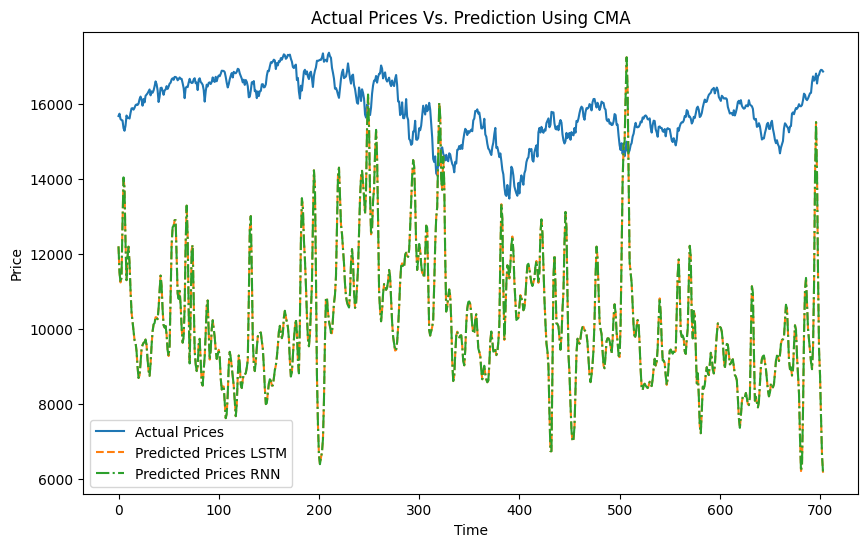

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 95458128.0000 - mae: 9622.9424 - val_loss: 166770272.0000 - val_mae: 12871.4697
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97569104.0000 - mae: 9732.8262 - val_loss: 166699072.0000 - val_mae: 12868.7275
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 97603120.0000 - mae: 9730.9502 - val_loss: 165183744.0000 - val_mae: 12810.0938
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 94491680.0000 - mae: 9572.6992 - val_loss: 153532816.0000 - val_mae: 12349.2275
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 83756128.0000 - mae: 9008.0615 - val_loss: 102364600.0000 - val_mae: 10075.2432
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 47264364.0000 - mae: 6662.1890 - val_loss: 9731402.0000 - val_mae: 2997.2014
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2656253.2500 - mae: 1326.3928 - val_loss: 2041541.2500 - val_mae: 916.9158
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 98008784.0000 - mae: 9752.3896 - val_loss: 166774432.0000 - val_mae: 12871.6318
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 96600152.0000 - mae: 9679.3994 - val_loss: 166735456.0000 - val_mae: 12870.1250
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 96310080.0000 - mae: 9665.5801 - val_loss: 165895808.0000 - val_mae: 12837.6406
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 95113688.0000 - mae: 9606.3027 - val_loss: 156743408.0000 - val_mae: 12477.5537
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 86357744.0000 - mae: 9145.9814 - val_loss: 103281200.0000 - val_mae: 10118.2588
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 45099820.0000 - mae: 6425.5024 - val_loss: 2730929.5000 - val_mae: 1476.1063
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1233260.8750 - mae: 848.6887 - val_loss: 1583546.0000 - val_mae: 920.6234
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

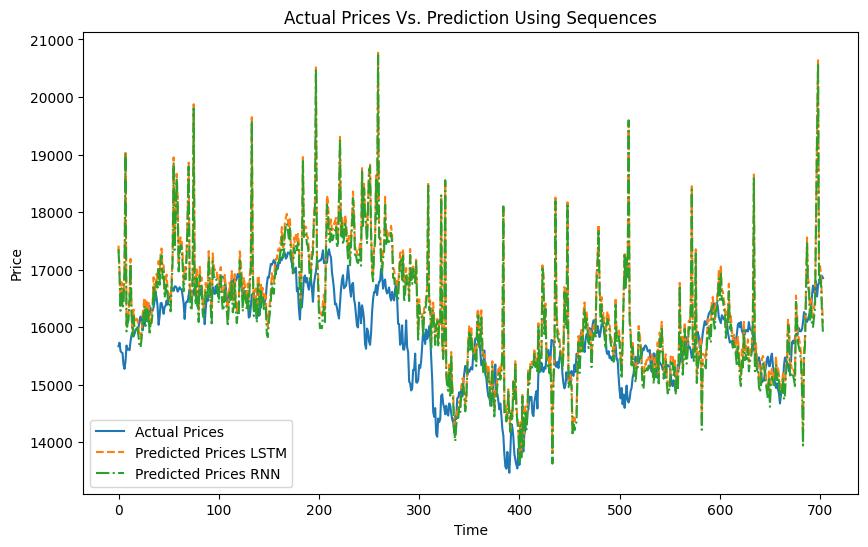

In [ ]:
tickers = ['^GSPC', # S&P 500
           '^DJI',  # Dow Jones
           '^IXIC', # NASDAQ
           '^RUT',  # Russell 2000
           '^NYA']  # NYSE Composite

# Download Stock data
for t in tickers:
    data = yf.download(t, start="2010-01-01", end="2023-12-31")

    # Drop NaN values from the dataset
    data.dropna(inplace=True)

    #Create models for LSTM and RNN networks using CMA
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data_cma(data, m)

    lstm_model_cma, lstm_predictions_cma, lstm_y_test_cma= predict_price_change_lstm_cma(X_train, X_val, X_test, y_train, y_val, y_test)
    rnn_model_cma, rnn_predictions_cma, rnn_y_test_cma = predict_price_change_rnn_cma(X_train, X_val, X_test, y_train, y_val, y_test)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", linestyle='-', marker=None)
    plt.plot(lstm_predictions_cma, label="Predicted Prices LSTM", linestyle='--', marker=None)
    plt.plot(lstm_predictions_cma, label="Predicted Prices RNN", linestyle='-.', marker=None)
    plt.legend()
    plt.title("Actual Prices Vs. Prediction Using CMA")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    #Create models for LSTM and RNN networks using Sequences
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data_seq(data, m)

    lstm_model_seq, lstm_predictions_seq, lstm_y_test_seq= predict_price_change_lstm_seq(X_train, X_val, X_test, y_train, y_val, y_test)
    rnn_model_seq, rnn_predictions_seq, rnn_y_test_seq = predict_price_change_rnn_seq(X_train, X_val, X_test, y_train, y_val, y_test)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", linestyle='-', marker=None)
    plt.plot(lstm_predictions_seq, label="Predicted Prices LSTM", linestyle='--', marker=None)
    plt.plot(rnn_predictions_seq, label="Predicted Prices RNN", linestyle='-.', marker=None)
    plt.legend()
    plt.title("Actual Prices Vs. Prediction Using Sequences")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()